In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Моделирование работы поплавкой электростанции

Ссылка на статьи:

1) Mechanical design and modeling of a single-piston pump for the novel power take-off system of a wave energy converter:
https://www.sciencedirect.com/science/article/pii/S0960148116303780  
2) "Dynamical modelling, analysis and optimization of a water blanket for the Ocean Grazer"
https://upcommons.upc.edu/entities/publication/de7eba85-928c-4102-a8a2-882155dd9ae0  

Упрощенная схема работы поплавковой электростанции

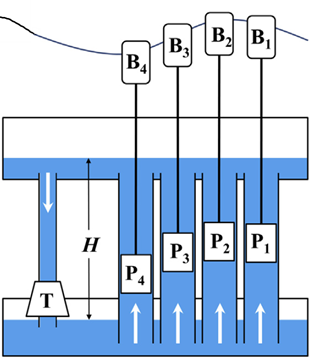

Расчетная схема

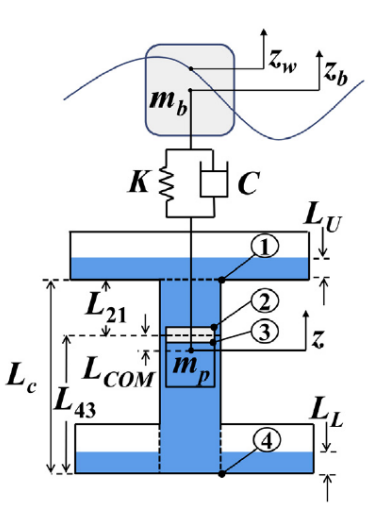

### Основные данные

**Основные константы:**

In [2]:
g     = 9.81      # m/s
ro_sw = 1035      # kg/m3
ro_w  = 1080      # kg/m3
ro_st = 7850      # kg/m3
E     = 2.1e11    # Pa
mu    = 0.0734    # Pa s

**Параметры волны (гармоническая):**

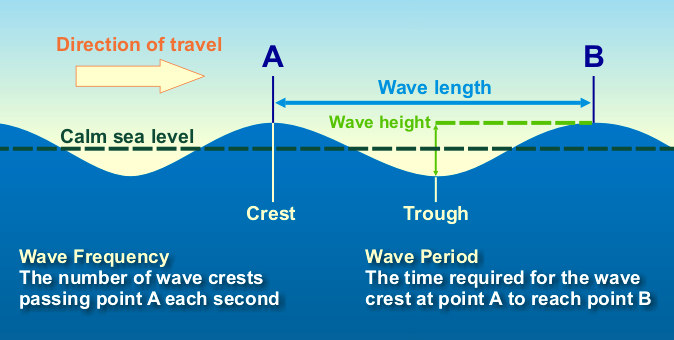

In [3]:
Tw = 10            # период волны, с 
Hw = 4             # высота волны, м
Lw = 30            # длина волны, м

Кинематические характеристики волны можно описать следующими формулами:
\begin{align}
z_w &= -\frac{H_w}{2} \cos\left( \frac{2\pi}{T_w} t \right) \\
\dot{z}_w &= \frac{\pi H_w}{T_w} \sin\left( \frac{2\pi}{T_w} t \right) \\
\ddot{z}_w &= \frac{2\pi^2 H_w}{T_w^2} \cos\left( \frac{2\pi}{T_w} t \right)
\end{align}

In [4]:
def wave_dynamic(t):
    zw = Hw / 2 * np.sin(2 * np.pi * t / Tw)
    dzw = Hw / 2 * 2* np.pi / Tw * np.cos(2 * np.pi * t / Tw)
    ddzw = -Hw / 2 * (2* np.pi / Tw)**2 * np.sin(2 * np.pi * t / Tw)
    return zw, dzw, ddzw

**Структурные параметры поплавка, поршня и штока:**

In [5]:
# параметры поплавка

In [6]:
mb = 1500                 # масса буя, кг
Hb = 2                    # высота буя, м
Ab = 49                   # площадь сечения буя, м^2
Ca = 0.9                  # коэффициент присоединенной массы
Cd = 1.5                  # коэффициент сопротивления буя

In [7]:
# параметры поршня

In [8]:
rpist = 0.1                  # радиус поршня, м
Apist = np.pi * rpist**2     # площадь поршня,   м^2
mpist = 150                  # масса поршня, кг
Hpist=0.1                    # высота поршня, м
spist=1e-3                      # зазор поршень цилиндр, м

In [9]:
# параметры штока

In [10]:
mr   = 100                               # масса штока,кг
Lr   = 170                               # длина штока, м
rr   = 0.04                              # радиус штока, м
mr   = ro_st * (np.pi * rr**2) * Lr
K    = (np.pi * rr**2 * E) / Lr          # жёсткость пружины, Н/м
Xi   = 5
C    = 2 * Xi * np.sqrt(mb * K)          # коэффициент демпфирования, Н·с/м

**Параметры резервуаров:**

In [11]:
Au = 49                   # площадь поперечного сечения верхнего резервуара,м^2
Lu = 10                   # начальный уровень верхнего резервуара, м
Ll = 30                   # начальный уровень нижнего резервуара, м
Lc = 100                  # расстояние между точками 1-4, м
Al = 49                   # площадь поперечного сечения нижнего резервуара, м

### Дифференциальные уравнения движения

$$
\begin{cases}
(m_1 +m_r/2) \, \ddot{z}_b + C(\dot{z}_b - \dot{z_p}) + K(z_b - (z_p-Lr)) +\rho_{sw} g A_b z_b  =  F_d + F_e \\[1em]
(m_r/2 + m_p + m_f) \, \ddot{z_p}   + C(\dot{z_p} - \dot{z}_b) + K(z_p - z_b) + \rho A_c \dot{z_p}^2  =  A_{pist}*p_4 - m_f g - B_p \dot{z}_p \\[1em]
\dot{p_1}   =  \rho_{w} g A_{pist}/{A_u}  \dot{z}_b \\[1em]
\dot{p_4}   =  \rho_{w} g A_{pist} / A_l   \dot{z}_b \\[1em]
\end{cases}
$$
здесь:

**Уравнения динамики поплавка:**
\begin{alignat*}{2}
F_K^{(b)} &= K(z_b - (z_p-L_r)) &&\text{— упругая сила в тросе (пружине)},\\
F_C^{(b)} &= C(\dot{z}_b - \dot{z}) &&\text{— демпфирующая сила в тросе},\\
F_d^{(b)} &= -\tfrac{1}{2}\rho_{sw} A_b C_d |\dot{z}_b| \dot{z}_b &&\text{— сила гидродинамического сопротивления},\\
F_e^{(b)} &= (\rho_{sw} g A_b z_w + m_a \ddot{z}_w)e^{-k_w D_b} &&\text{— возбуждающая сила от волны}.
\end{alignat*}

**Восстанавливающая сила плавучести:** $\rho_{sw} g A_b z_b$


В равновесии на плавучее тело действуют две силы — сила тяжести и сила Архимеда,  
которые уравновешивают друг друга:

$$
F_g = m_b g, \qquad F_b = \rho_{sw} g A_b T
$$

где  
$ m_b $ — масса буя,  
$ A_b $ — площадь поперечного сечения,  
$ T $ — осадка в равновесии,  
$ \rho_{sw} \$ — плотность морской воды.

В состоянии равновесия:

$$
F_b = F_g
$$

В динамических условиях рассматриваются только возмущения относительно равновесия.  
Поэтому статические силы $ F_b $ и $ F_g $ исключаются,  
а их разность описывается **восстанавливающей силой плавучести** $ f_{hs} $:

$$
f_{hs} = \rho_{sw} g A_b z_b
$$

где $z_b$ — вертикальное смещение буя относительно положения равновесия.

Эта сила направлена противоположно смещению и эквивалентна действию линейной пружины с жёсткостью

$$
k_h = \rho_{sw} g A_b
$$

***Такое представление используется в линейной теории малых возмущений (см. Falnes, Ocean Waves and Oscillating Systems, 2002)***

**Уравнение движения поршня (ход вверх / ход вниз)**

Движение поршня в цилиндре описывается двумя уравнениями — для **хода вверх (upstroke)**, когда поршень поднимает столб жидкости, и **хода вниз (downstroke)**, когда он опускается под действием веса и гидростатического давления.

---
**Сила прокачки при ходе "вверх" (Pumping Force)**

Сила, создаваемая поршнем при перемещении рабочей жидкости, определяется  с учётом динамики столба жидкости:

$$
F_p =
A_c (p_1 - p_4)
+ \rho A_c (L_{21} + L_U + L_{43})(\ddot{z} + g)
+ \rho A_c \dot{z}^{\,2}
$$

где:

| Обозначение | Описание |
|:-------------|:----------|
| $(p_1, p_4)$ | давления в верхнем и нижнем резервуарах |
| $(L_{21}, L_{43})$ | высоты жидкостных столбов над и под поршнем |
| $(L_U)$ | уровень верхнего резервуара |
| $(\dot{z}, \ddot{z})$ | скорость и ускорение поршня |
| $(\rho)$ | плотность рабочей жидкости |
| $(g)$ | ускорение свободного падения |

---
Тогда различие ходов выглядет следующим образом:

⬆️ Ход вверх (Upstroke)

Во время хода вверх клапаны открыты, поршень перекачивает жидкость из нижнего резервуара в верхний.  
К уравнению добавляется масса жидкого столба \( m_f \) и вес жидкости.

$$
(m_r + m_p + m_f)\,\ddot{z}_p =
C(\dot{\xi} - \dot{z}_p)
+ K(\xi - z_p - L_r)
+ A_c (p_4 - p_1)
- B_p \dot{z}_p
- m_f g
$$

- $( m_f )$ — масса жидкости, движущейся с поршнем (fluid column mass)  
- $( F_p = A_c (p_4 - p_1) )$ — сила прокачки (pumping force)

---

⬇️ Ход вниз (Downstroke)

Во время хода вниз клапаны закрыты, поршень опускается свободно, не перекачивая жидкость.  
Масса жидкости \( m_f \) не действует на поршень, а давление в резервуарах считается постоянным.

$$
(m_r + m_p)\,\ddot{z}_p =
C(\dot{\xi} - \dot{z}_p)
+ K(\xi - z_p - L_r)
+ A_c (p_4 - p_1)
- B_p \dot{z}_p
$$

- $( F_p = 0 )$ (жидкость не перекачивается)
- Давления $( p_1, p_4 )$ остаются постоянными

**Ключевые различия**

| Параметр | Ход вверх (Upstroke) | Ход вниз (Downstroke) |
|:----------|:---------------------|:-----------------------|
| Масса жидкости $(m_f)$ | действует на поршень | не учитывается |
| Клапаны | открыты | закрыты |
| Сила прокачки $(F_p)$ | \(A_c(p_4 - p_1)\) | \(0\) |
| Давления $(p_1, p_4)$ | изменяются со временем | постоянные |
| Направление скорости $(\dot{z}_p)$ | \(> 0\) | \(< 0\) |



Основные слагаемые
\begin{alignat*}{2}
F_g^{(p)} &= -m_f g &&\text{— сила тяжести поршня (с присоединенной массой)},\\
F_K^{(p)} &= -K((z_p-L_r) - z_b) &&\text{— упругая сила в соединении с буем},\\
F_C^{(p)} &= -C(\dot{z_p} - \dot{z}_b) &&\text{— демпфирующая сила},\\
F_p^{(p)} &= A_{pist}(p_4 - p_2) &&\text{— сила давления рабочей жидкости по обе стороны поршня},\\
F_i^{(p)} &= -\rho A_{pist} \dot{z_p}^2 &&\text{— инерционная сила жидкости}.
\end{alignat*}

**Уравнения для давлений в верхнем и нижнем резервуарах**

Из закона сохранения объёма рабочей жидкости:

$$
Q = A_c \dot{z}
$$

где $( Q )$ — расход (поток) жидкости, $( A_c )$ — площадь поперечного сечения поршня,  
$( \dot{z} )$ — скорость перемещения поршня.

Тогда при учёте гидростатического баланса давления в резервуарах получаем:

$$
\dot{p}_1 = \rho g \frac{A_c}{A_U} \, \dot{z}
\qquad \text{и} \qquad
\dot{p}_4 = - \rho g \frac{A_c}{A_L} \, \dot{z}
$$

где:

| Обозначение | Описание |
|:-------------|:----------|
| $(\dot{p}_1, \dot{p}_4)$ | изменение давления в верхнем и нижнем резервуарах |
| $(A_c)$ | площадь поперечного сечения цилиндра (поршня) |
| $(A_U, A_L)$ | площади сечений верхнего и нижнего резервуаров |


**Мы говорили ранее, что Python не содержит встроенных функций для решения дифференциальных уравнений второго и выше порядков**. Однако **эта система уравнений может быть сведена к системе уравнений первого порядка**.

Конкретно в данном случае имеем:

* $\dot{z_b} = v_b $
* $\dot{z_p} = v_p $

Получаем следующую систему уравнений:
$$
\begin{cases}
m_1 \, \dot{v}_b + C(v_b - v_p) + K(z_b - z_p)  = -  \rho_{sw} g A_b z_b + F_d(v_b) + F_e(z_b,t) \\[1em]
v_b = \dot{z_b}   \\[1em]
m_2 \, \dot{v_p}   + C(v_p - v_b) + K(z_p - z_b)  = - \rho A_{pist} v_p^2 + A_{pist} p_4 - m_f g \\[1em]
v   = \dot{z}     \\[1em]
\dot{p_1}   =  \rho_{w} g A_{pist} / A_u  v_p \\[1em]
\dot{p_4}   =  \rho_{w} g A_{pist} / A_l  v_p \\[1em]
\end{cases}
$$

### Действующие силы и массы

Важную роль имеет величина **Db**, насколько глубоко поплавок погружен в морскую воду в любой заданный момент времени:
\begin{equation}
D_b = z_w - z_b + \frac{1}{2} H_b
\end{equation}
в зависимости от ее значения можно найти величину действующей силы Архимеда

In [12]:
def depth_b(z_w, z_b): # величина погружения поплавка
    return z_w - z_b +0.5*Hb

**Эффективная маса поплавка**
\begin{equation}
m_{1plus} = 
\begin{cases}
0, & \text{if } D_b \leq 0 \\
 C_a \rho_{sw}  A_b D_b, & \text{if } 0 < D_b \leq H_b \\
 C_a \rho_{sw}  A_b H_b, & \text{if } D_b > H_b
\end{cases}
\end{equation}

где:
- $m_{1plus}$ — присоединенная масса поплавка;  
- $C_a$ — коэффициент присоединенной массы
- $\rho_{sw}$ — плотность морской воды, кг/м$^3$;  
- $A_b$ — площадь поперечного сечения поплавка, м$^2$;  
- $D_b = z_w - z_b + \frac{1}{2} H_b$ — глубина погружения буя, м;  
- $H_b$ — высота поплавка, м.

In [13]:
def m1(z_w, z_b): # общая масса буя
    Db = depth_b(z_w, z_b)
    #print(Db)
    mass = mb 
    if Db <= 0:  
        m_added = 0.0
    elif (Db>0) and (Db<Hb):
        m_added = Ca * ro_sw * Ab * Db
    else:
        m_added = Ca * ro_sw * Ab * Hb
    return mass + m_added

**Эффективная маса поршня(c учетом выражения для силы прокачки)**
$$
m_{\text{eff,up}} = m_r + m_p + m_f,
$$

$$
m_f = \rho \, A_c \left( L_c + \frac{p_1}{\rho g} \right)
$$

In [14]:
# дело такое........ сложное, поэтому явно запишем, без использования функции

**Сила сопротивления**
\begin{equation}
\ F_d = -\frac{1}{2} \rho_{\text{sw}} A_b C_d | \dot{z}_b | \dot{z}_b 
\end{equation}

где:

- $F_d$ — сила сопротивления, действующая на буй (направлена противоположно скорости движения), Н;  
- $\rho_{sw}$ — плотность морской воды, кг/м$^3$;  
- $A_b$ — площадь поперечного сечения поплавка буя, м$^2$;  
- $C_d$ — коэффициент сопротивления (drag coefficient), безразмерный;  
- $\dot{z}_b$ — скорость вертикального двипоплавкаия буя, м/с;  
- $|\dot{z}_b|$ — модуль скорости, учитывающий направление силы сопротивления.

In [15]:
def drag_force(v_b): # Сила сопротивления
    Fd = - 0.5 * ro_sw * Ab * Cd * abs(v_b) * v_b  # сила сопротивления
    return Fd

**Возбуждающая сила от волны (внешняя динамическая сила, вызывающая движение поплавка под действием волны)**
\begin{equation}
\ F_e = (m_a \ddot{z}_w  + \rho_{\text{sw}} g A_b z_w) e^{-k_w D_b}
\end{equation}

где:

- $F_e$ — возбуждающая сила, действующая на буй, Н;  
- $m_a$ — добавленная масса буя (added mass), кг;  
- $\ddot{z}_w$ — ускорение поверхности волны, м/с$^2$;  
- $B$ — коэффициент демпфирования волны (wave damping coefficient), Н·с/м;  
- $\dot{z}_w$ — скорость колебания поверхности волны, м/с;  
- $\rho_{sw}$ — плотность морской воды, кг/м$^3$;  
- $g$ — ускорение свободного падения, м/с$^2$;  
- $A_b$ — площадь поперечного сечения буя, м$^2$;  
- $z_w$ — вертикальное смещение поверхности волны, м;  
- $k_w = \dfrac{2\pi}{\lambda_w}$ — волновое число, м$^{-1}$;  
- $\lambda_w$ — длина волны, м;  
- $D_b$ — глубина погружения поплавка, м.  

In [16]:
def excitation_force(zw, dzw, ddzw, zb): # Сила от волны возбуждающая
    kw  = 2*np.pi/Lw;                                            # Волновое число
    Db = depth_b(zw, zb)                                         # глубина погружения буя
    mass = m1(zw, zb) - mb
    Fe = (mass * ddzw + ro_sw * g * Ab * zw) * np.exp(-kw * Db)  # волновое возбуждение   
    return Fe

### Решение системы уравнений

Создадим функцию для правой части уравнений:

Отдельно  отметим, про "демфирование" присоединенной массы к поршню:  Во время работы поршня масса столба жидкости $(m_f)$ изменяется:  
при **ходе вверх (upstroke)** она возрастает, так как поршень поднимает воду, а при **ходе вниз (downstroke)** — уменьшается, поскольку жидкость перестаёт двигаться вместе с поршнем.

Чтобы избежать резких скачков между этими состояниями, вводится **демпфирующее (плавное) изменение массы жидкости**, описываемое экспоненциальной функцией:

$$
m_f = \frac{1}{2} \left( 1 + \tanh(G \, v_p) \right) \, m_{f,\text{add}}
$$

где добавочная масса жидкости вычисляется как:

$$
m_{f,\text{add}} = \rho_w A_p \left( L_c + \frac{p_1}{\rho_w g} \right)
$$

---
| Символ | Описание |
|:--------|:----------|
| $( m_f )$ | текущая эффективная масса жидкости |
| $( m_{f,\text{add}} $ | добавочная масса жидкого столба в цилиндре |
| $( \rho_w )$ | плотность рабочей жидкости |
| $( A_p )$ | площадь поршня |
| $( L_c )$ | длина цилиндра |
| $( p_1 )$ | давление в верхнем резервуаре |
| $( g )$ | ускорение свободного падения |
| $( v_p)$ | скорость поршня |
| $( G )$ | коэффициент сглаживания (чем больше, тем резче переход) |

---

**Физический смысл**

- При **ходе вверх** $((v_p > 0)) → (\tanh(Gv_p) \to 1)$, значит $(m_f \approx m_{f,\text{add}})$: жидкость полностью вовлечена в движение.  
- При **ходе вниз** $((v_p < 0)) → (\tanh(Gv_p) \to -1)$, значит $(m_f \approx 0)$: жидкость не движется вместе с поршнем.  
- При $(v_p = 0)$ переход между состояниями плавный и симметричный.

Таким образом, $( m_f(v_p) )$ изменяется непрерывно и дифференцируемо, что устраняет численные осцилляции при смене направления движения поршня.

In [17]:
def rhs_b(t, val):
    z_b, v_b = val  # распаковка переменных состояния
    # Параметры волны
    z_w, dz_w, ddz_w = wave_dynamic(t)
    # Силы 
    Fd = drag_force(v_b)
    Fe = excitation_force(z_w, dz_w, ddz_w, z_b)
    # Уравнения движения поплавка
    rhs1 =  v_b
    rhs2 = (- ro_sw * g * Ab * z_b + Fe + Fd  ) / m1(z_w, z_b)
    return [rhs1, rhs2]    

In [18]:
z0_w, dz0_w, _ = wave_dynamic(0)
val_0 = [z0_w, dz0_w]
t_span = (0, 5*Tw) 
t_eval = np.linspace(*t_span, 20000)  
sol = solve_ivp(rhs_b, t_span, val_0, t_eval=t_eval, method='Radau')  
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.500e-03 ...  5.000e+01  5.000e+01]
        y: [[ 0.000e+00  3.138e-03 ... -7.576e-02 -7.323e-02]
            [ 1.257e+00  1.253e+00 ...  1.010e+00  1.010e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1320
     njev: 51
      nlu: 242

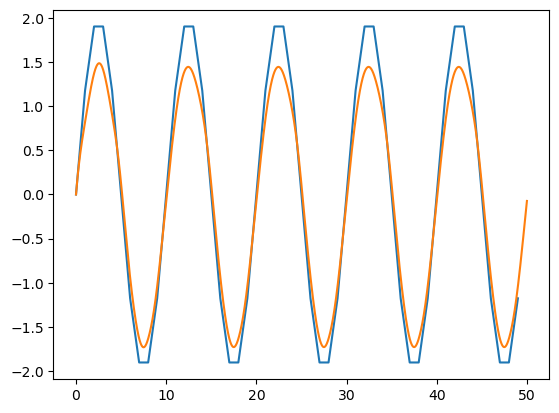

In [19]:
z_w_rez = [wave_dynamic(ti)[0] for ti in range(0,50) ]
plt.plot(range(0,50), z_w_rez)
plt.plot(sol.t, sol.y[0])

In [20]:
def rhs(t, val):
    z_b, v_b, z_p, v_p, p1, p4  = val  # распаковка переменных состояния
    # Параметры волны
    z_w, dz_w, ddz_w = wave_dynamic(t)
    # Силы 
    Fd = drag_force(v_b)
    Fe = excitation_force(z_w, dz_w, ddz_w, z_b)
    # Уравнения движения поплавка
    rhs1 =  v_b
    rhs2 = (-(K + ro_sw * g * Ab)*z_b - C*v_b + K*z_p + C*v_p + Fe + Fd  + K*Lr) / m1(z_w, z_b)
    # Уравнения движения поршня
    rhs3 =  v_p
    mf_add   = ro_w*Apist*(Lc+p1/ro_w/g)
    G = 500
    mf = 0.5*(1 + np.tanh(G*v_p))*mf_add  
    m2 = mpist + mr + mf
    Bp = 2.0 * np.pi * rpist * Hpist * mu / spist
    rhs4 = (K*z_b  + C*v_b - K*z_p -  C*v_p - Bp *v_p + Apist*(p4-p1) - K*Lr - mf*g)/ m2
    # Уравнения изменения давления(уровня воды) в резервуарах
    rhs5 =   ro_w*g*Apist/ Au * np.maximum(v_p, 0.0)        
    rhs6 = - ro_w*g*Apist/ Al * np.maximum(v_p, 0.0)        
    return [rhs1, rhs2, rhs3, rhs4, rhs5, rhs6]

Начальные условия:

In [21]:
z0_w, dz0_w, _ = wave_dynamic(0)
val_0 = [z0_w, dz0_w, z0_w-Lr, dz0_w, ro_w*g*Lu, ro_w*g*Ll]

Используем численный решатель из библиотеки scipy

In [22]:
t_span = (0, 5*Tw) 
t_eval = np.linspace(*t_span, 20000)  
sol = solve_ivp(rhs, t_span, val_0, t_eval=t_eval, method='Radau')  
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.500e-03 ...  5.000e+01  5.000e+01]
        y: [[ 0.000e+00  3.138e-03 ... -1.421e-01 -1.397e-01]
            [ 1.257e+00  1.253e+00 ...  9.594e-01  9.596e-01]
            ...
            [ 1.059e+05  1.059e+05 ...  1.061e+05  1.061e+05]
            [ 3.178e+05  3.178e+05 ...  3.177e+05  3.177e+05]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4044
     njev: 178
      nlu: 886

распаковка решения уравнения

In [23]:
t = t_eval

In [24]:
zw, vw, aw = wave_dynamic(t)          # параметры волны
zb, vb, zp, vp, p1, p4 = sol.y        # решение уравнений
ab = np.gradient(vb, t)               # ускорение буя
ap = np.gradient(vp, t)               # ускорение поршня

### Анализ результатов

**Характеристики поплавка**

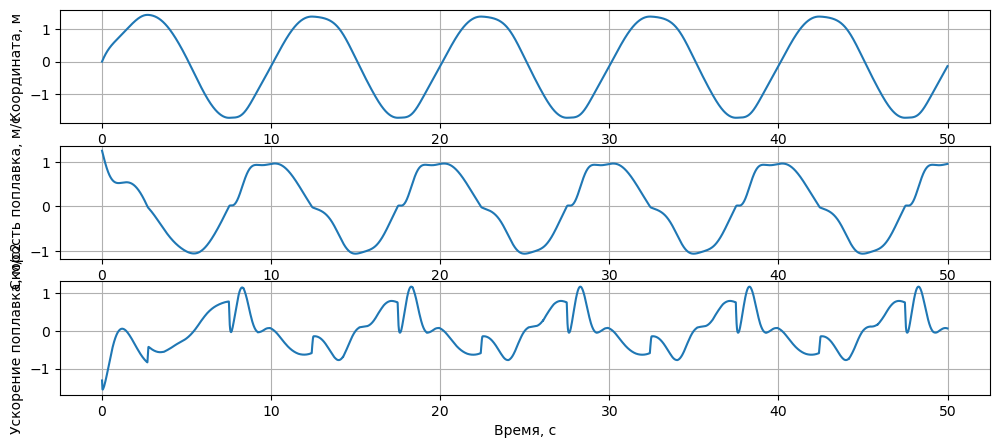

In [25]:
plt.figure(figsize=(12, 5)) 
plt.subplot(3, 1, 1)
plt.plot(t, zb)
plt.ylabel("Координата, м")
plt.xlabel("Время, с")
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, vb)
plt.ylabel("Скорость поплавка, м/с")
plt.xlabel("Время, с")
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, ab)
plt.ylabel("Ускорение поплавка, м/с2")
plt.xlabel("Время, с")
plt.grid()

**Характеристики поршня**

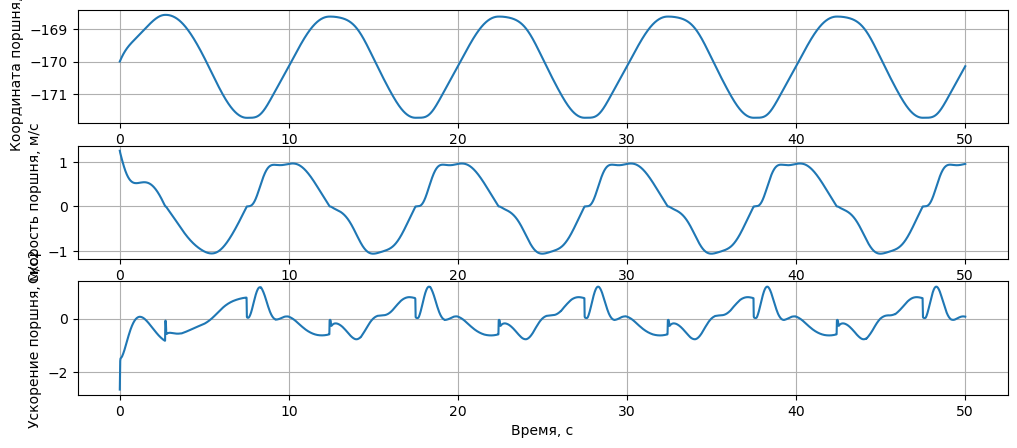

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(3, 1, 1)
plt.plot(t, zp)
plt.ylabel("Координата поршня, м")
plt.xlabel("Время, с")
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, vp)
plt.ylabel("Скорость поршня, м/с")
plt.xlabel("Время, с")
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, ap)
plt.ylabel("Ускорение поршня, м/с2")
plt.xlabel("Время, с")
plt.grid()

**Расчёт сил**

In [27]:
Fhs =  - ro_sw * g * Ab*zb                                                          # восстанавливающая сила плавучести
Fd  =  drag_force(vb)                                                              # сила сопротивления
Fe  = [excitation_force(zw[i], vw[i], aw[i], zb[i]) for i in range (len(t))]       # возбуждающая сила от волны
Fk = -K*(zb - zp) 
Fc = -C*(vb - vp)
Fbuoy = Fe + Fhs + Fd 

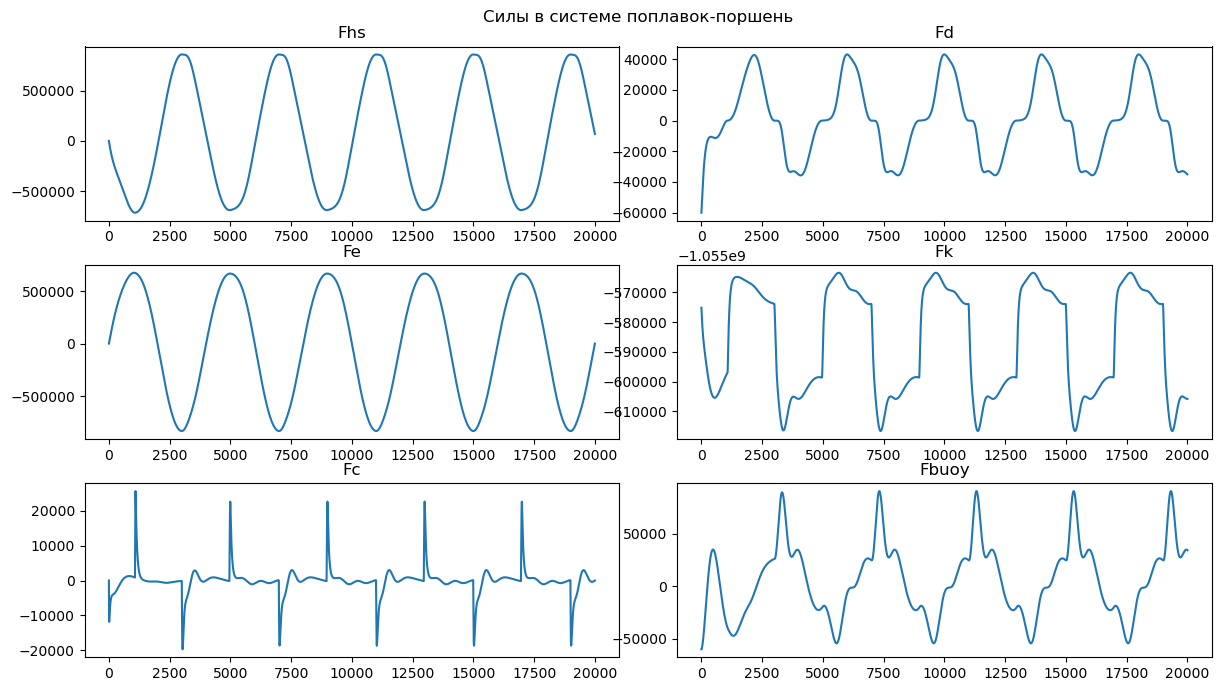

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
fig.suptitle('Силы в системе поплавок-поршень', fontsize=12)
plt.tight_layout()
ax[0,0].set_title('Fhs')
ax[0,0].plot(Fhs, label ='Fhs')
ax[0,1].set_title('Fd')
ax[0,1].plot(Fd, label ='Fd')
ax[1,0].set_title('Fe')
ax[1,0].plot(Fe, label ='Fe')
ax[1,1].set_title('Fk')
ax[1,1].plot(Fk, label ='Fk')
ax[2,0].set_title('Fc')
ax[2,0].plot(Fc, label ='Fc')
ax[2,1].set_title('Fbuoy')
ax[2,1].plot(Fbuoy, label ='Fbuoy')
plt.show()

**Энергия/мощность накачки**

In [29]:
# мощность на поплавке
Pbuoy = Fbuoy*vb
# мощность перекачки
Pp = (-  Apist*(p4-p1) + ro_w*Apist*(Lc+p1/ro_w/g)*(ap+g)) * np.maximum(vp, 0.0)           

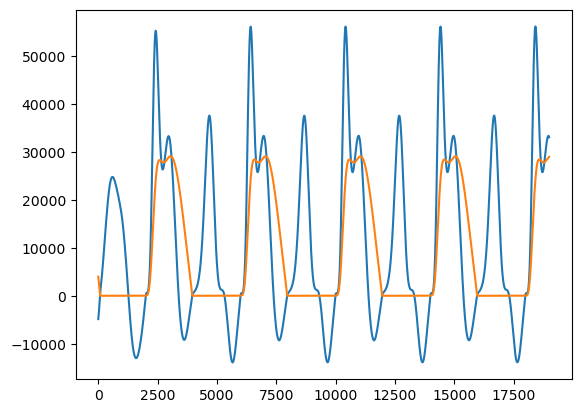

In [30]:
plt.plot(Pbuoy[1000:])
plt.plot(Pp[1000:])

In [31]:
# Будем смотреть баланс для последнего периода волны, когда все устаканилось
t_start = 4*Tw
mask = np.where(t > t_start)[0]

In [32]:
E_pump = np.trapz(Pp[mask], t[mask])                                # энергия накачки
E_buoy  = np.trapz(Pbuoy[mask], t[mask])                            # энергия на поплавке
efficiency = E_pump / E_buoy * 100                                  # эффективность системы
print('КПД преобразователя волны:',efficiency) 

КПД преобразователя волны: 82.99924681790434
